### **Dictionnaire polluants**

In [1]:
 
POLLUANTS_CONFIG = {
    "NO2": {"var": "nitrogendioxide_tropospheric_column", "unite": "µmol/m²"},
    "CO": {"var": "carbonmonoxide_total_column", "unite": "µmol/m²"},
    "CH4": {"var": "methane_mixing_ratio", "unite": "mixing_ratio"},
    "O3": {"var": "ozone_total_vertical_column", "unite": "µmol/m²"},
    "SO2": {"var": "sulfurdioxide_total_vertical_column", "unite": "µmol/m²"},
    "HCHO": {"var": "formaldehyde_tropospheric_vertical_column","unite": "µmol/m²" },
    "AER_AI": {"var": "aerosol_index_340_380", "unite": "AOD"} # pour les PM, aérosols
}

### **Traitement des données et Rasters moyens Journaliers, mensuels ou annuels**

# NOMS ET TITRES PERSONNALISES

In [13]:
import os
import numpy as np
import rasterio
import xarray as xr
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gpd
from scipy.spatial import cKDTree
from rasterio.transform import from_origin
import re

#  Extraction des heures depuis le nom du fichier
def extract_times_from_filename(filename):
    match = re.search(r"(\d{8}T\d{6})_(\d{8}T\d{6})", filename)
    if match:
        return match.group(1)[9:], match.group(2)[9:]  # Extraction HHMMSS
    return None, None

#  Génération de la grille
def create_parallelogram_grid(lat_min, lat_max, lon_min, lon_max, dx, dy):
    polygons, centers = [], []
    for x in np.arange(lon_min, lon_max, dx):
        for y in np.arange(lat_min, lat_max, dy):
            p = Polygon([
                (x, y), (x + dx, y), (x + dx + dy / 2, y + dy), (x + dy / 2, y + dy)
            ])
            polygons.append(p)
            centers.append(Point(x + dx / 2, y + dy / 2))
    return gpd.GeoDataFrame(geometry=polygons), centers

#  Fonction principale de traitement
def process_netcdf_to_raster(year, pollutant, base_dir, qa_min=0.75, month=None, day=None):
    pollutant = pollutant.upper()
    if pollutant not in POLLUANTS_CONFIG:
        print(f" Polluant '{pollutant}' non reconnu.")
        return

    var_name = POLLUANTS_CONFIG[pollutant]["var"]
    periods = [f"{year}_{month}"] if month else [f"{year}_{m:02d}" for m in range(1, 13)]

    # Recherche des fichiers NetCDF
    files = []
    for period in periods:
        input_dir = os.path.join(base_dir, pollutant, period)
        if os.path.exists(input_dir):
            files.extend([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".nc")])

    # 🔹 Filtrer les fichiers correspondant exactement à la date demandée
    if day:
        files = [f for f in files if f"{year}{month}{day}" in os.path.basename(f)]

    #  Si aucun fichier n'existe pour cette date, on arrête ici
    if not files:
        print(f" Aucun fichier NetCDF trouvé pour {pollutant} le {day}/{month}/{year}. Pas de raster généré.")
        return

    #  Détermination des heures min/max
    times = [extract_times_from_filename(os.path.basename(f)) for f in files]
    start_times = sorted([t[0] for t in times if t[0] is not None])
    end_times = sorted([t[1] for t in times if t[1] is not None])

    first_start_time = start_times[0] if start_times else "000000"
    last_end_time = end_times[-1] if end_times else "235959"

    #  Définition de la grille
    lat_min, lat_max = 42.3, 45.4
    lon_min, lon_max = 3.63, 8
    resolution_x, resolution_y = 0.1, 0.06
    grid, grid_centers = create_parallelogram_grid(lat_min, lat_max, lon_min, lon_max, resolution_x, resolution_y)

    sum_values = np.zeros(len(grid), dtype=np.float32)
    count_values = np.zeros(len(grid), dtype=np.int32)

    for file in files:
        ds = xr.open_dataset(file, group="PRODUCT")
        data_array = ds[var_name].isel(time=0).values.astype(np.float32)
        qa = ds["qa_value"].isel(time=0).values.astype(np.float32)
        lat = ds["latitude"].values.astype(np.float32)
        lon = ds["longitude"].values.astype(np.float32)
        ds.close()

        df = pd.DataFrame({
            "lat": lat.ravel(),
            "lon": lon.ravel(),
            "value": data_array.ravel(),
            "qa_value": qa.ravel()
        })
        df = df[df["qa_value"] >= qa_min]
        df = df[(df["lat"] >= lat_min) & (df["lat"] <= lat_max) & 
                (df["lon"] >= lon_min) & (df["lon"] <= lon_max)]

        if df.empty:
            continue

        tree = cKDTree(np.array([[p.x, p.y] for p in grid_centers]))
        indices = tree.query(df[['lon', 'lat']].values)[1]

        for i, idx in enumerate(indices):
            sum_values[idx] += df['value'].iloc[i]
            count_values[idx] += 1

    mean_values = np.full(len(grid), np.nan, dtype=np.float32)
    valid_cells = count_values > 0
    mean_values[valid_cells] = sum_values[valid_cells] / count_values[valid_cells]
    grid["mean_value"] = mean_values

    #  Vérification finale avant export
    if np.isnan(mean_values).all():
        print(f" Aucun pixel valide trouvé. Pas de raster généré pour {pollutant} le {day}/{month}/{year}.")
        return

    # Définition du fichier de sortie
    if day:
        output_name = f"{pollutant}_mean_{year}_{month}_{day}_T{first_start_time}-{last_end_time}.tif"
    elif month:
        output_name = f"{pollutant}_mean_{year}_{month}.tif"
    else:
        output_name = f"{pollutant}_mean_{year}.tif"

    print(f" Génération du raster : {output_name}")

    # Création du raster
    raster_size_x = len(np.arange(lon_min, lon_max, resolution_x))
    raster_size_y = len(np.arange(lat_min, lat_max, resolution_y))
    transform = from_origin(lon_min, lat_max, resolution_x, resolution_y)

    raster_data = np.full((raster_size_y, raster_size_x), np.nan, dtype=np.float32)
    for idx, row in grid.iterrows():
        poly = row.geometry
        x_idx = int((poly.centroid.x - lon_min) / resolution_x)
        y_idx = int((lat_max - poly.centroid.y) / resolution_y)
        if 0 <= x_idx < raster_size_x and 0 <= y_idx < raster_size_y:
            raster_data[y_idx, x_idx] = row["mean_value"]

    output_dir = os.path.join(base_dir, pollutant, "output_rasters")
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_name)

    with rasterio.open(output_path, 'w', driver='GTiff', height=raster_size_y, width=raster_size_x,
                       count=1, dtype='float32', crs='EPSG:4326', transform=transform) as dst:
        dst.write(raster_data, 1)

    print(f" Raster enregistré sous {output_path}")

# Exemples d'utilisation :
POLLUANTS_CONFIG = {
    "NO2": {"var": "nitrogendioxide_tropospheric_column", "unite": "µmol/m²"},
    "CO": {"var": "carbonmonoxide_total_column", "unite": "µmol/m²"},
    "CH4": {"var": "methane_mixing_ratio", "unite": "mixing_ratio"},
    "O3": {"var": "ozone_total_vertical_column", "unite": "µmol/m²"},
    "SO2": {"var": "sulfurdioxide_total_vertical_column", "unite": "µmol/m²"},
    "HCHO": {"var": "formaldehyde_tropospheric_vertical_column","unite": "µmol/m²" },
    "AER_AI": {"var": "aerosol_index_340_380", "unite": "AOD"} # pour les PM, aérosols
}

base_dir = "N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output"
process_netcdf_to_raster("2024", "SO2", base_dir, month="08", day="01")  # Raster journalier, AER_AI, O3


 Génération du raster : SO2_mean_2024_08_01_T112621-130751.tif
 Raster enregistré sous N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output\SO2\output_rasters\SO2_mean_2024_08_01_T112621-130751.tif


### **Visualisation des données**

Recherche : N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output\SO2\output_rasters\SO2_mean_2024_08_01_T*.tif
1 fichiers trouvés
Fichier sélectionné : SO2_mean_2024_08_01_T112621-130751.tif
Sauvegarde réussie : N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output\SO2\graphes\SO2_2024_08_01_T112621-130751.png


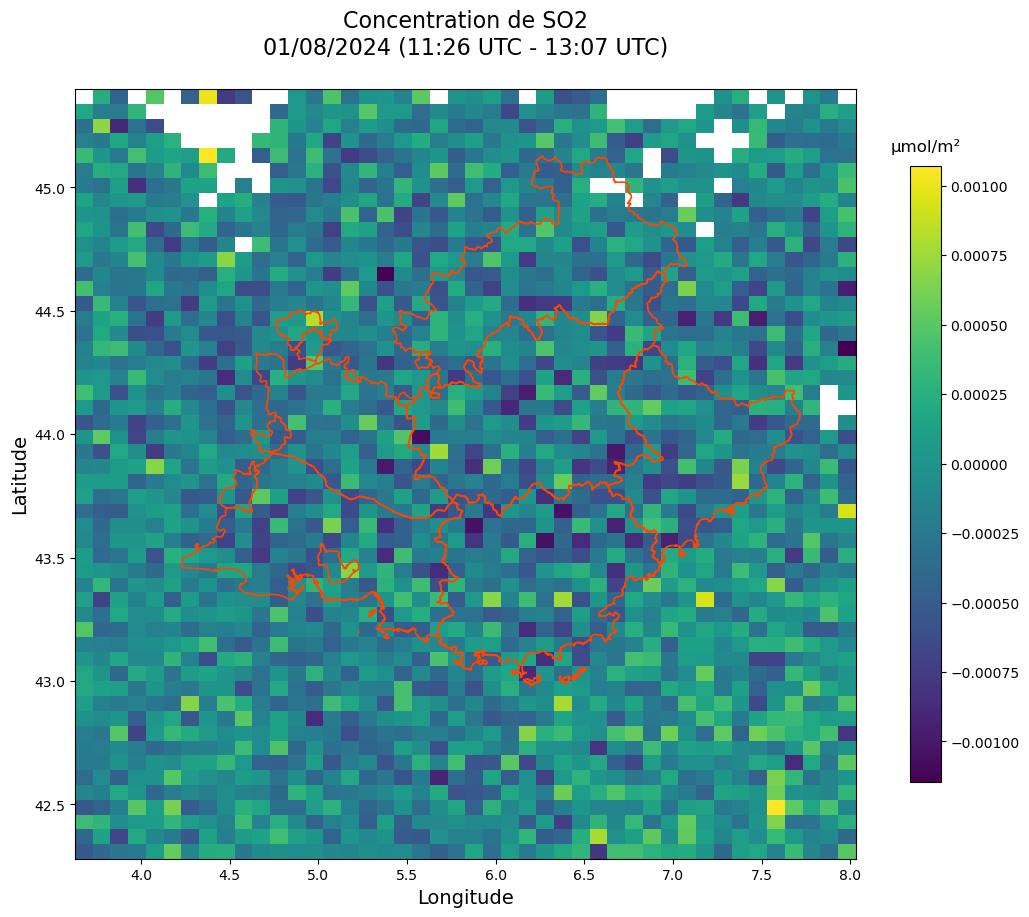

In [14]:
from datetime import datetime
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from rasterio.plot import show


POLLUANTS_CONFIG = {
    "NO2": {"var": "nitrogendioxide_tropospheric_column", "unite": "µmol/m²"},
    "CO": {"var": "carbonmonoxide_total_column", "unite": "µmol/m²"},
    "CH4": {"var": "methane_mixing_ratio", "unite": "mixing_ratio"},
    "O3": {"var": "ozone_total_vertical_column", "unite": "µmol/m²"},
    "SO2": {"var": "sulfurdioxide_total_vertical_column", "unite": "µmol/m²"},
    "HCHO": {"var": "formaldehyde_tropospheric_vertical_column","unite": "µmol/m²" },
    "AER_AI": {"var": "FinalAerosolOpticalDepth", "unite": "AOD"} # pour les PM, aérosols
}

def parse_filename(filename):
    """Extrait les composants temporels du nom de fichier avec regex"""
    pattern = r"(\w+)_mean_(\d{4})_(\d{2})_(\d{2})_T(\d+-\d+)"
    match = re.match(pattern, filename)
    if match:
        return {
            'polluant': match.group(1),
            'year': match.group(2),
            'month': match.group(3),
            'day': match.group(4),
            'time': match.group(5)
        }
    return None

def format_timestamp(date_str, time_str=None):
    """Formate les dates/heures avec gestion des erreurs"""
    try:
        date_obj = datetime.strptime(date_str, "%Y_%m_%d")
        if time_str:
            start, end = time_str.split('-')
            start_time = datetime.strptime(start, "%H%M%S").strftime("%H:%M UTC")
            end_time = datetime.strptime(end, "%H%M%S").strftime("%H:%M UTC")
            return {
                'date_display': date_obj.strftime("%d/%m/%Y"),
                'time_display': f"{start_time} - {end_time}",
                'file_suffix': f"{date_str}_T{time_str}"
            }
        return {
            'date_display': date_obj.strftime("%B %Y") if len(date_str) > 7 else date_str,
            'file_suffix': date_str
        }
    except ValueError as e:
        print(f"Erreur de format de date : {e}")
        return None

def visualize_raster(date, polluant="NO2", raster_dir=None, shp_path=None):
    polluant = polluant.upper()
    if polluant not in POLLUANTS_CONFIG:
        print(f"Polluant '{polluant}' non pris en charge")
        return

    # Configuration des chemins réels
    base_path = "N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output"
    if raster_dir is None:
        raster_dir = os.path.join(base_path, polluant, "output_rasters")
    
    # Vérification de l'existence du répertoire
    if not os.path.exists(raster_dir):
        print(f"Répertoire introuvable : {raster_dir}")
        return

    # Construction du pattern de recherche basé sur la date
    if len(date) == 8:  # Journalier (YYYYMMDD)
        year = date[:4]
        month = date[4:6]
        day = date[6:8]
        search_pattern = f"{polluant}_mean_{year}_{month}_{day}_T*.tif"
    elif len(date) == 6:  # Mensuel (YYYYMM)
        year = date[:4]
        month = date[4:6]
        search_pattern = f"{polluant}_mean_{year}_{month}.tif"
    elif len(date) == 4:  # Annuel (YYYY)
        search_pattern = f"{polluant}_mean_{date}.tif"
    else:
        print("Format de date invalide")
        return

    # Recherche précise du fichier
    full_pattern = os.path.join(raster_dir, search_pattern)
    matching_files = glob.glob(full_pattern)
    
    print(f"Recherche : {full_pattern}")
    print(f"{len(matching_files)} fichiers trouvés")

    if not matching_files:
        print(f"Aucun raster correspondant à {date}")
        return
    
    # Sélection du fichier le plus récent
    raster_path = sorted(matching_files, key=os.path.getmtime)[-1]
    print(f"Fichier sélectionné : {os.path.basename(raster_path)}")

    # Extraction des métadonnées
    filename = os.path.basename(raster_path).split('.')[0]
    meta = parse_filename(filename)
    
    if not meta:
        print("Format de fichier invalide")
        return

    # Formatage des dates
    date_str = f"{meta['year']}_{meta['month']}_{meta['day']}"
    time_info = format_timestamp(date_str, meta.get('time'))
    
    if not time_info:
        return

    # Création du titre
    title_template = {
        8: f"Concentration de {polluant}\n{time_info['date_display']} ({time_info['time_display']})",
        6: f"Moyenne mensuelle de {polluant}\n{time_info['date_display']}",
        4: f"Moyenne annuelle de {polluant}\n{meta['year']}"
    }
    plot_title = title_template.get(len(date), "Visualisation des données")

    # Chargement des données
    try:
        with rasterio.open(raster_path) as src:
            data = src.read(1)
            data = np.ma.masked_where(data == src.nodata, data)
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    except Exception as e:
        print(f"Erreur de chargement : {e}")
        return

    # Visualisation
    fig, ax = plt.subplots(figsize=(14, 10))
    img = ax.imshow(data, extent=extent, 
                    #cmap=POLLUANTS_CONFIG[polluant]['cmap'], 
                    origin='upper',
                    aspect='auto')

    # Ajout du shapefile
    if shp_path and os.path.exists(shp_path):
        gdf = gpd.read_file(shp_path)
        gdf.boundary.plot(ax=ax, edgecolor='#FF4500', linewidth=1.2, linestyle='-')

    # Configuration du graphique
    ax.set_title(plot_title, fontsize=16, pad=25)
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)
    
    cbar = fig.colorbar(img, ax=ax, shrink=0.8)
    
    cbar.ax.set_title(POLLUANTS_CONFIG[polluant]['unite'], fontsize=12, pad=10) 
    # Sauvegarde
    output_dir = os.path.join(base_path, polluant, "graphes")
    os.makedirs(output_dir, exist_ok=True)
    
    output_path = os.path.join(output_dir, f"{polluant}_{time_info['file_suffix']}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
    print(f"Sauvegarde réussie : {output_path}")
    
    plt.show()
    plt.close()

# Exemple d'utilisation avec debug
shp_path = "N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/Stage_Moussa/fichiers_shp/contour_region_4326.shp"
visualize_raster(date="20240801", polluant="SO2", shp_path=shp_path) # NO2, O3, CO


## PALETTE DE COULEUR DE COPERNICUS

Recherche : N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output\NO2\output_rasters\NO2_mean_2024_08_02_T*.tif
1 fichiers trouvés


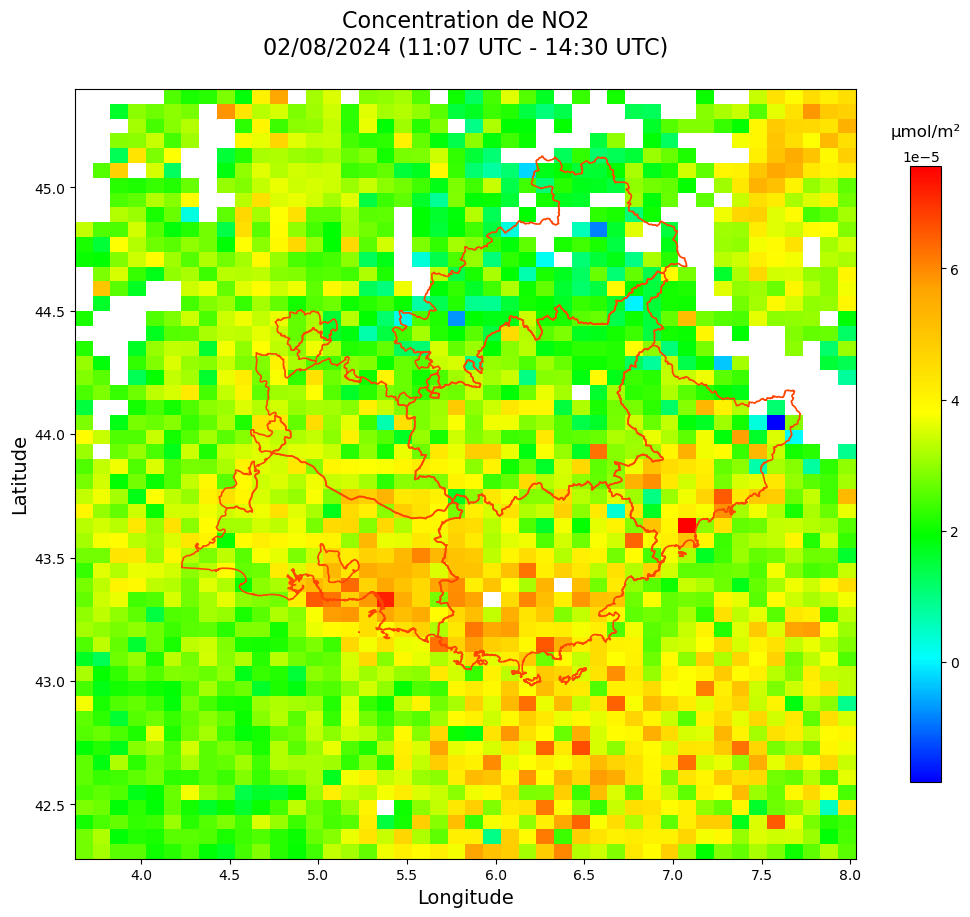

Sauvegarde réussie : N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output\NO2\graphes\NO2_2024_08_02_T110715-143014.png


In [103]:
from datetime import datetime
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from matplotlib.colors import LinearSegmentedColormap

# Définir la palette Copernicus
copernicus_colors = [
    "#0000FF",  # Bleu
    "#00FFFF",  # Cyan
    "#00FF00",  # Vert
    "#FFFF00",  # Jaune
    "#FFA500",  # Orange
    "#FF0000"   # Rouge
]
copernicus_colormap = LinearSegmentedColormap.from_list("Copernicus", copernicus_colors)

POLLUANTS_CONFIG = {
    "NO2": {"var": "nitrogendioxide_tropospheric_column", "unite": "µmol/m²"},
    "CO": {"var": "carbonmonoxide_total_column", "unite": "µmol/m²"},
    "CH4": {"var": "methane_mixing_ratio", "unite": "mixing_ratio"},
    "O3": {"var": "ozone_total_vertical_column", "unite": "µmol/m²"},
    "SO2": {"var": "sulfurdioxide_total_vertical_column", "unite": "µmol/m²"},
    "HCHO": {"var": "formaldehyde_tropospheric_vertical_column","unite": "µmol/m²" },
    "AER_AI": {"var": "FinalAerosolOpticalDepth", "unite": "AOD"} 
}

def parse_filename(filename):
    """Extrait les composants temporels du nom de fichier avec regex"""
    pattern = r"(\w+)_mean_(\d{4})_(\d{2})_(\d{2})_T(\d+-\d+)"
    match = re.match(pattern, filename)
    if match:
        return {
            'polluant': match.group(1),
            'year': match.group(2),
            'month': match.group(3),
            'day': match.group(4),
            'time': match.group(5)
        }
    return None

def format_timestamp(date_str, time_str=None):
    """Formate les dates/heures avec gestion des erreurs"""
    try:
        date_obj = datetime.strptime(date_str, "%Y_%m_%d")
        if time_str:
            start, end = time_str.split('-')
            start_time = datetime.strptime(start, "%H%M%S").strftime("%H:%M UTC")
            end_time = datetime.strptime(end, "%H%M%S").strftime("%H:%M UTC")
            return {
                'date_display': date_obj.strftime("%d/%m/%Y"),
                'time_display': f"{start_time} - {end_time}",
                'file_suffix': f"{date_str}_T{time_str}"
            }
        return {
            'date_display': date_obj.strftime("%B %Y") if len(date_str) > 7 else date_str,
            'file_suffix': date_str
        }
    except ValueError as e:
        print(f"Erreur de format de date : {e}")
        return None

def visualize_raster(date, polluant="NO2", raster_dir=None, shp_path=None):
    polluant = polluant.upper()
    if polluant not in POLLUANTS_CONFIG:
        print(f"Polluant '{polluant}' non pris en charge")
        return

    base_path = "N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/alternance_moussa/output"
    if raster_dir is None:
        raster_dir = os.path.join(base_path, polluant, "output_rasters")
    
    if not os.path.exists(raster_dir):
        print(f"Répertoire introuvable : {raster_dir}")
        return

    if len(date) == 8:  
        year = date[:4]
        month = date[4:6]
        day = date[6:8]
        search_pattern = f"{polluant}_mean_{year}_{month}_{day}_T*.tif"
    elif len(date) == 6:  
        year = date[:4]
        month = date[4:6]
        search_pattern = f"{polluant}_mean_{year}_{month}.tif"
    elif len(date) == 4:  
        search_pattern = f"{polluant}_mean_{date}.tif"
    else:
        print("Format de date invalide")
        return

    full_pattern = os.path.join(raster_dir, search_pattern)
    matching_files = glob.glob(full_pattern)
    
    print(f"Recherche : {full_pattern}")
    print(f"{len(matching_files)} fichiers trouvés")

    if not matching_files:
        print(f"Aucun raster correspondant à {date}")
        return
    
    raster_path = sorted(matching_files, key=os.path.getmtime)[-1]
    
    filename = os.path.basename(raster_path).split('.')[0]
    meta = parse_filename(filename)
    
    if not meta:
        print("Format de fichier invalide")
        return

    date_str = f"{meta['year']}_{meta['month']}_{meta['day']}"
    time_info = format_timestamp(date_str, meta.get('time'))
    
    if not time_info:
        return

    title_template = {
        8: f"Concentration de {polluant}\n{time_info['date_display']} ({time_info['time_display']})",
        6: f"Moyenne mensuelle de {polluant}\n{time_info['date_display']}",
        4: f"Moyenne annuelle de {polluant}\n{meta['year']}"
    }
    
    plot_title = title_template.get(len(date), "Visualisation des données")

    try:
        with rasterio.open(raster_path) as src:
            data = src.read(1)
            data = np.ma.masked_where(data == src.nodata, data)
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
            
            fig, ax = plt.subplots(figsize=(14, 10))
            img = ax.imshow(data, extent=extent, cmap=copernicus_colormap, origin='upper', aspect='auto')

            if shp_path and os.path.exists(shp_path):
                gdf = gpd.read_file(shp_path)
                gdf.boundary.plot(ax=ax, edgecolor='#FF4500', linewidth=1.2)

            ax.set_title(plot_title, fontsize=16, pad=25)
            ax.set_xlabel("Longitude", fontsize=14)
            ax.set_ylabel("Latitude", fontsize=14)

            cbar = fig.colorbar(img, ax=ax, shrink=0.8)
            cbar.ax.set_title(POLLUANTS_CONFIG[polluant]['unite'], fontsize=12, pad=10)

            output_dir = os.path.join(base_path, polluant, "graphes")
            os.makedirs(output_dir, exist_ok=True)

            output_path = os.path.join(output_dir, f"{polluant}_{time_info['file_suffix']}.png")
            plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
            
            plt.show()
            
            plt.close()
            
            print(f"Sauvegarde réussie : {output_path}")
            
    except Exception as e:
        print(f"Erreur lors du traitement : {e}")

# Exemple d'utilisation avec debug
shp_path="N:/MOD_SERVER/SATELLITES/tropomi_s5_annuel/Stage_Moussa/fichiers_shp/contour_region_4326.shp"
visualize_raster(date="20240802", polluant="NO2", shp_path=shp_path)
